In [204]:
# Importing the libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.stats as stats
import random

In [205]:
# Load the dataset
dataset = pd.read_csv(r'input/data/240624_validation_data.csv')

# Extract the time, forecasted demand and actual demand
time = dataset['time']
time = pd.to_datetime(time, utc=True)
forecast_demand = dataset['predicted heat']
actual_demand = dataset['delivered heat']

# Create a dataframe
df_data = pd.DataFrame({'time' : time, 'actual_demand': actual_demand, 'forecast_demand': forecast_demand})
df_data['hour']=time.dt.hour

# Calculate the error and absolute error
df_data['error']= df_data['actual_demand'] - df_data['forecast_demand']

# Calculate the mean of the error for whole dataset
mu_all = df_data['error'].mean()
sigma_all = df_data['error'].std()
print('Mean of the mean of the error of each hour:', mu_all)
print('Standard deviation of the mean of the error of each hour:', sigma_all)

Mean of the mean of the error of each hour: -8.39020298257356
Standard deviation of the mean of the error of each hour: 31.42172005784749


In [206]:
# Select the date for which you want to extract the data
selected_date = '2023-04-01'

# Extract the data for the selected date
daily_date = df_data[df_data['time'].dt.date == pd.to_datetime(selected_date).date()].reset_index(drop=True)
daily_date = daily_date[['time', 'hour', 'actual_demand', 'forecast_demand', 'error']]
if(len(daily_date)==24):
    print('The selected date has 24 hours')
else:
    print('The selected date does not have 24 hours')

daily_date

The selected date has 24 hours


,time,hour,actual_demand,forecast_demand,error
0,2023-04-01 00:00:00+00:00,0,45.141668,79.256436,-34.114768
1,2023-04-01 01:00:00+00:00,1,71.408335,88.850384,-17.442050
2,2023-04-01 02:00:00+00:00,2,234.970838,166.624694,68.346144
3,2023-04-01 03:00:00+00:00,3,146.212502,113.137177,33.075326
4,2023-04-01 04:00:00+00:00,4,131.770836,118.939521,12.831315
5,2023-04-01 05:00:00+00:00,5,129.470836,124.614834,4.856001
6,2023-04-01 06:00:00+00:00,6,160.633337,125.941581,34.691755
7,2023-04-01 07:00:00+00:00,7,168.050002,118.988194,49.061808
8,2023-04-01 08:00:00+00:00,8,162.475003,113.102637,49.372366
9,2023-04-01 09:00:00+00:00,9,96.350001,103.574392,-7.224391


---

## First Methode

In [207]:
# Calculate the mean and standard deviation of the error of each hour
error = df_data.groupby('hour')['error'].agg(['mean', 'std']).reset_index()
error  = error.rename(columns={'mean': 'mu', 'std': 'sigma'})

In [208]:
# Generate scenarios for the selected date
num_scenarios = 1000
forecast_demand = daily_date['forecast_demand']

scenarios = np.zeros((num_scenarios, 24))

for i in range(24):
    mu = error.loc[error['hour'] == i, 'mu'].values[0]
    sigma = error.loc[error['hour'] == i, 'sigma'].values[0]

    hourly_scenarios = np.random.normal(mu, sigma, num_scenarios)

    scenarios[:, i] = forecast_demand[i] + hourly_scenarios

scenarios = pd.DataFrame(scenarios)
scenarios


,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,88.161524,78.094468,136.662345,122.225672,78.759334,107.645709,125.704084,94.072813,111.746302,137.752822,...,17.939781,71.510837,123.797843,128.513156,119.703957,123.851127,103.042091,13.526772,103.741240,84.747158
1,34.270148,120.400091,236.934483,95.927190,90.817494,125.998425,83.646515,99.758422,110.269159,129.201020,...,65.129598,105.462959,101.341587,118.397138,163.430565,69.661564,39.973892,54.234522,55.203601,49.052762
2,100.667225,32.495138,192.882538,117.142690,86.736954,88.655604,92.653428,137.145902,91.664040,26.699190,...,127.730618,90.946158,99.844803,141.964965,114.314814,100.352621,53.909221,40.697028,41.501327,64.547487
3,92.207728,80.180197,177.310921,134.592020,151.597086,139.975147,84.210176,62.278564,63.687553,94.209974,...,78.525672,84.051728,133.042726,104.546017,100.291237,73.369016,41.028651,45.786305,46.793430,2.373256
4,84.300469,78.316195,305.335790,114.214047,123.449955,125.921936,117.487422,141.108267,92.865173,87.235259,...,96.221909,61.861490,113.122309,152.112362,102.892083,125.387357,61.201386,46.415650,76.414564,62.732374
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,94.857488,91.372301,167.539682,35.330621,126.499583,116.080342,113.100224,64.272744,136.963206,81.218559,...,97.138878,107.188364,135.592388,103.943923,144.946152,87.290577,127.532806,26.061029,78.563246,41.987121
996,124.973676,63.169472,185.202713,123.735165,115.447437,105.222511,213.512862,148.288885,90.408216,64.264108,...,95.613387,120.199340,33.185601,100.592049,108.575945,117.029404,30.930050,103.798804,30.517254,72.940409
997,78.470500,95.923404,127.147219,73.734557,138.632765,105.702572,120.702420,127.475787,93.189694,76.924864,...,71.505522,146.762655,102.332804,97.407505,70.806621,156.599489,24.564542,49.217407,14.848799,40.059945
998,53.610510,82.877622,126.990476,93.798271,105.435212,148.925149,123.100875,125.760921,111.956274,61.315612,...,84.821310,85.910924,124.798875,112.194663,100.417731,61.154493,38.422098,57.204064,96.248933,66.171959


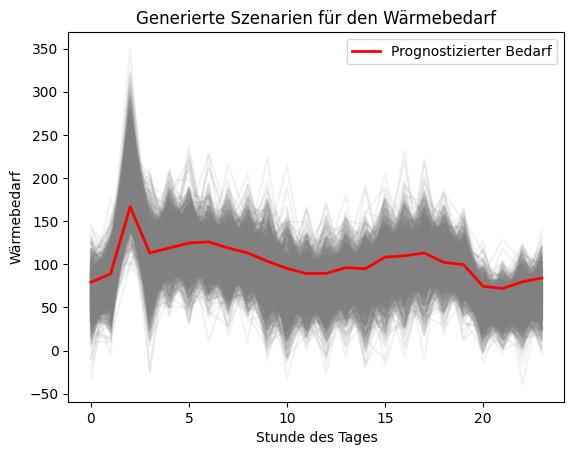

In [209]:
plt.plot(scenarios.T, color='grey', alpha=0.1)  # alle Szenarien plotten
plt.plot(daily_date['forecast_demand'], color='red', linewidth=2, label='Prognostizierter Bedarf')
plt.xlabel('Stunde des Tages')
plt.ylabel('Wärmebedarf')
plt.title('Generierte Szenarien für den Wärmebedarf')
plt.legend()
plt.show()

---

## Second Methode: Monte Carlo Sampling and Roulette Wheel Mechanism


In [210]:
# number of intervals
num_intervals = 7  
intervals = np.linspace(mu_all - 3*sigma_all, mu_all + 3*sigma_all, 8)
interval_centers = (intervals[:-1] + intervals[1:]) / 2  
print('Intervals:',intervals)
print('Interval Centers:',interval_centers)

# calculate the probabilities
probabilities = [stats.norm.cdf(intervals[i+1], mu_all, sigma_all) - stats.norm.cdf(intervals[i], mu_all, sigma_all) for i in range(len(intervals)-1)]
cum_probabilities = np.cumsum(probabilities)

# print the probabilities
print('Probabilities:',probabilities)
print('Edge on Scale 0.XX-0.99X Probabilities:',cum_probabilities)

# Function to randomly select an interval based on the CDF

def select_interval(cumulative_probabilities):
    rnd = random.random()
    for i, cp in enumerate(cumulative_probabilities):
        if rnd <= cp:
            return i
    return len(cumulative_probabilities) - 1


Intervals: [-102.65536316  -75.72246025  -48.78955734  -21.85665444    5.07624847
   32.00915138   58.94205428   85.87495719]
Interval Centers: [-89.1889117  -62.2560088  -35.32310589  -8.39020298  18.54269992
  45.47560283  72.40850574]
Probabilities: [0.014712387572198223, 0.08320911123950271, 0.2348461740542938, 0.33176485820475055, 0.23484617405429364, 0.0832091112395027, 0.014712387572198171]
Edge on Scale 0.XX-0.99X Probabilities: [0.01471239 0.0979215  0.33276767 0.66453253 0.89937871 0.98258782
 0.9973002 ]


In [211]:
# Generate scenarios
T = 24  # Number of time steps
num_scenarios = 1000  # Number of scenarios
scenarios = []

for _ in range(num_scenarios):
    scenario = []
    for t in range(T):
        interval_index = select_interval(cum_probabilities)
        scenario.append(interval_centers[interval_index])
    scenarios.append(scenario)

    
# Calculate normed probability for each scenario
scenario_probabilities = np.prod([[probabilities[select_interval(cum_probabilities)] for _ in range(T)] for _ in range(num_scenarios)], axis=1)
normalized_probabilities = scenario_probabilities / scenario_probabilities.sum()

# Convert scenarios to DataFrame for better visualization
scenarios_mu_df = pd.DataFrame(scenarios, columns=[f'Time_{t}' for t in range(T)])
probabilities_df = pd.DataFrame(normalized_probabilities, columns=['Probability'])


In [212]:
# Add the predicted thermal demand to the error scenarios to get the actual thermal demand scenarios
scenarios_df = scenarios_mu_df.apply(lambda row: daily_date['forecast_demand'] + row.values, axis=1)
scenarios_df

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,70.866233,80.460181,131.301588,131.679877,56.683512,116.224631,117.551378,110.597991,104.712434,68.251286,...,113.369270,99.863435,128.377950,104.731255,93.876092,118.194823,119.978086,90.515757,71.314195,48.739920
1,124.732039,26.594376,131.301588,77.814071,110.549318,116.224631,90.618476,164.463797,50.846628,122.117092,...,113.369270,126.796338,74.512144,131.664158,93.876092,145.127726,66.112281,63.582854,44.381292,75.672823
2,43.933330,80.460181,158.234491,23.948265,164.415124,89.291728,144.484281,110.597991,50.846628,68.251286,...,59.503464,180.662144,182.243756,131.664158,66.943189,64.329017,66.112281,63.582854,71.314195,102.605726
3,43.933330,26.594376,131.301588,158.612780,137.482221,89.291728,63.685573,110.597991,131.645337,95.184189,...,86.436367,72.930532,155.310853,104.731255,93.876092,118.194823,119.978086,36.649951,17.448389,48.739920
4,17.000427,80.460181,185.167394,104.746974,83.616415,143.157534,117.551378,56.732185,104.712434,41.318383,...,59.503464,72.930532,101.445047,104.731255,66.943189,64.329017,93.045184,90.515757,17.448389,48.739920
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,70.866233,107.393084,158.234491,77.814071,83.616415,143.157534,117.551378,83.665088,104.712434,41.318383,...,113.369270,126.796338,74.512144,158.597060,93.876092,118.194823,93.045184,63.582854,44.381292,129.538628
996,97.799136,107.393084,185.167394,131.679877,83.616415,89.291728,144.484281,137.530894,104.712434,95.184189,...,32.570561,99.863435,128.377950,50.865449,120.808995,64.329017,39.179378,117.448660,125.180001,75.672823
997,124.732039,80.460181,212.100297,104.746974,110.549318,170.090437,144.484281,56.732185,158.578240,95.184189,...,86.436367,126.796338,101.445047,158.597060,93.876092,118.194823,66.112281,63.582854,44.381292,75.672823
998,124.732039,53.527278,185.167394,50.881168,110.549318,89.291728,117.551378,110.597991,104.712434,122.117092,...,113.369270,99.863435,128.377950,131.664158,66.943189,91.261920,39.179378,9.717048,98.247098,48.739920
